In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aim-2023/train.parquet
/kaggle/input/aim-2023/submission.csv


In [2]:
tr = pd.read_parquet('/kaggle/input/aim-2023/train.parquet')
sample_submission = pd.read_csv('/kaggle/input/aim-2023/submission.csv')

tr

,Values
0_0_0,133.0
0_0_1,114.0
0_0_2,140.0
0_0_3,106.0
0_0_4,117.0
...,...
169_2_17751,65.5
169_2_17752,65.5
169_2_17753,64.9
169_2_17754,64.7


In [3]:
'''
pd.Index - это нечто очень похожее на pd.Series
Так что все, что вы хотели бы сделать с индексом, как если бы он был pd.Series,
    скорее всего можно сделать...
'''
index_split = tr.index.str.split('_')
index_split

Index([      ['0', '0', '0'],       ['0', '0', '1'],       ['0', '0', '2'],
             ['0', '0', '3'],       ['0', '0', '4'],       ['0', '0', '5'],
             ['0', '0', '6'],       ['0', '0', '7'],       ['0', '0', '8'],
             ['0', '0', '9'],
       ...
       ['169', '2', '17746'], ['169', '2', '17747'], ['169', '2', '17748'],
       ['169', '2', '17749'], ['169', '2', '17750'], ['169', '2', '17751'],
       ['169', '2', '17752'], ['169', '2', '17753'], ['169', '2', '17754'],
       ['169', '2', '17755']],
      dtype='object', length=9055560)

In [4]:
'''
#забавно
У колонок из листов в пандасе тоже есть .str API.
Вытащить i-й элемент списка по всем колонкам можно через .str.get(i)
'''
tr['row_num'] = index_split.str.get(0)
tr['row_type'] = index_split.str.get(1)
tr['timestamp'] = index_split.str.get(-1).astype(int)
tr['row_id'] = tr.row_num + '_' + tr.row_type # "уникальный" ряд - уникальная пара (row_num, row_type)
tr # в таком виде можно сохранить себе на диск в .parquet, чтобы не делать долгих операций каждый раз

,Values,row_num,row_type,timestamp,row_id
0_0_0,133.0,0,0,0,0_0
0_0_1,114.0,0,0,1,0_0
0_0_2,140.0,0,0,2,0_0
0_0_3,106.0,0,0,3,0_0
0_0_4,117.0,0,0,4,0_0
...,...,...,...,...,...
169_2_17751,65.5,169,2,17751,169_2
169_2_17752,65.5,169,2,17752,169_2
169_2_17753,64.9,169,2,17753,169_2
169_2_17754,64.7,169,2,17754,169_2


In [5]:
'''
Формат не особо удобен, т.к. мы привыкли, что один объект изучения - одна строка.
Почти любую ситуацию вида "данные что надо, а формат не совсем подходящий"
    pandas умеет решать в одну-две строчки.
'''
X = tr.pivot(index='row_id', columns='timestamp', values='Values') # это быстро

'''
Видим, что сортировочка индекса поехала из-за того что .pivot зачем-то сортирует индекс и колонки
    (для этого перевели timestamp в int)
'''
X

timestamp,0,1,2,3,4,5,6,7,8,9,...,17746,17747,17748,17749,17750,17751,17752,17753,17754,17755
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.0000,429.0000,430.0000
0_1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.1450,0.1480,0.1488
0_2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.5000,62.3000,61.8000
100_0,124.0000,125.0000,127.0000,121.0000,121.0000,132.0000,124.0000,116.0000,116.0000,118.0000,...,261.0000,281.0000,222.0000,254.0000,284.0000,286.0000,264.0000,281.0000,288.0000,291.0000
100_1,0.0493,0.0475,0.0486,0.0481,0.0478,0.0496,0.0446,0.0467,0.0443,0.0494,...,0.0873,0.0932,0.0763,0.0874,0.0970,0.0905,0.0824,0.0915,0.0985,0.1079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0472,0.0425,0.0491,0.0449,0.0421,0.0526,0.0474,0.0495,0.0403,0.0504,...,0.0848,0.0901,0.0935,0.0825,0.0894,0.0941,0.0950,0.0864,0.0924,0.0833
99_2,64.1000,63.4000,62.2000,62.4000,64.3000,61.4000,61.1000,59.1000,61.0000,57.9000,...,58.4000,56.8000,58.0000,58.9000,57.8000,58.4000,57.3000,57.5000,57.0000,59.3000
9_0,256.0000,210.0000,224.0000,208.0000,188.0000,211.0000,178.0000,189.0000,169.0000,171.0000,...,670.0000,789.0000,769.0000,655.0000,690.0000,732.0000,684.0000,684.0000,724.0000,744.0000


In [6]:
X.columns = ['tr_' + str(col) for col in X.columns]
X.head(3) # исправим ситуацию

,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,...,tr_17746,tr_17747,tr_17748,tr_17749,tr_17750,tr_17751,tr_17752,tr_17753,tr_17754,tr_17755
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.000,429.000,430.0000
0_1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.145,0.148,0.1488
0_2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.500,62.300,61.8000


In [7]:
for i in range(100):
    X.loc[:, f'pred_{i}'] = X.iloc[:, -100] # предсказываем "100 таймстемпов назад"

X.iloc[:, -105:]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


,tr_17751,tr_17752,tr_17753,tr_17754,tr_17755,pred_0,pred_1,pred_2,pred_3,pred_4,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,509.0000,462.0000,412.0000,429.0000,430.0000,476.0000,470.0000,455.0000,492.0000,456.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.0000,429.0000,430.0000
0_1,0.1643,0.1621,0.1450,0.1480,0.1488,0.2282,0.2960,0.2095,0.2499,0.2135,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.1450,0.1480,0.1488
0_2,62.7000,62.7000,62.5000,62.3000,61.8000,42.7000,40.2000,43.5000,43.2000,43.8000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.5000,62.3000,61.8000
100_0,286.0000,264.0000,281.0000,288.0000,291.0000,231.0000,211.0000,211.0000,212.0000,214.0000,...,261.0000,281.0000,222.0000,254.0000,284.0000,286.0000,264.0000,281.0000,288.0000,291.0000
100_1,0.0905,0.0824,0.0915,0.0985,0.1079,0.0781,0.0758,0.0786,0.0741,0.0800,...,0.0873,0.0932,0.0763,0.0874,0.0970,0.0905,0.0824,0.0915,0.0985,0.1079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0941,0.0950,0.0864,0.0924,0.0833,0.1030,0.1045,0.1029,0.0995,0.0994,...,0.0848,0.0901,0.0935,0.0825,0.0894,0.0941,0.0950,0.0864,0.0924,0.0833
99_2,58.4000,57.3000,57.5000,57.0000,59.3000,63.3000,62.5000,62.6000,62.2000,62.2000,...,58.4000,56.8000,58.0000,58.9000,57.8000,58.4000,57.3000,57.5000,57.0000,59.3000
9_0,732.0000,684.0000,684.0000,724.0000,744.0000,602.0000,538.0000,555.0000,591.0000,569.0000,...,670.0000,789.0000,769.0000,655.0000,690.0000,732.0000,684.0000,684.0000,724.0000,744.0000


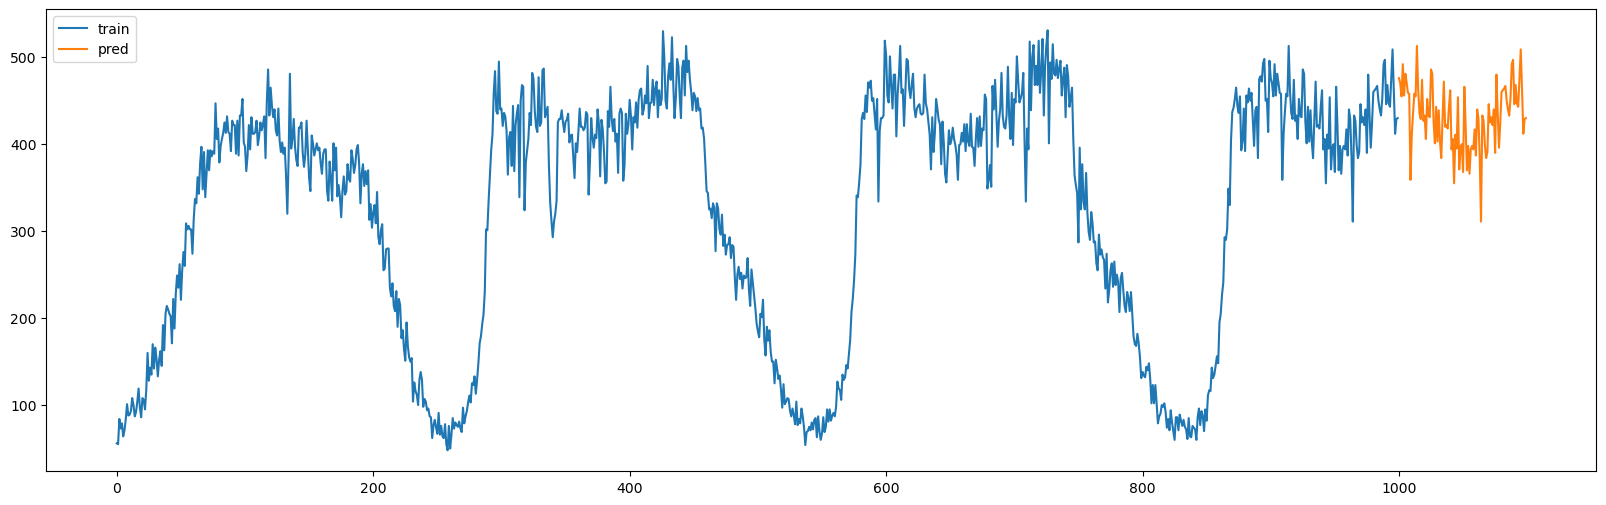

In [8]:
# нарисуем хвост из 1100 значений вместе с предсказанными
hue_col = ['train'] * 1000 + ['pred'] * 100

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=np.arange(1100), y=X.iloc[0, -1100:].values, hue=hue_col, n_boot=0)
plt.gcf().set_size_inches(20, 6)

In [9]:
'''
Можно запариться и сделать так, чтобы конец трейна был соединен с началом предикта :)
    но мы не будем...
Итак, нас интересует:
'''
from IPython.display import display

display(X.iloc[:, -100:])
sample_submission.head(3)

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,476.0000,470.0000,455.0000,492.0000,456.0000,481.0000,471.0000,459.0000,458.0000,359.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.0000,429.0000,430.0000
0_1,0.2282,0.2960,0.2095,0.2499,0.2135,0.2354,0.2473,0.2543,0.3139,0.3323,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.1450,0.1480,0.1488
0_2,42.7000,40.2000,43.5000,43.2000,43.8000,44.8000,42.6000,41.3000,38.3000,33.6000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.5000,62.3000,61.8000
100_0,231.0000,211.0000,211.0000,212.0000,214.0000,232.0000,188.0000,206.0000,195.0000,182.0000,...,261.0000,281.0000,222.0000,254.0000,284.0000,286.0000,264.0000,281.0000,288.0000,291.0000
100_1,0.0781,0.0758,0.0786,0.0741,0.0800,0.0772,0.0647,0.0705,0.0738,0.0704,...,0.0873,0.0932,0.0763,0.0874,0.0970,0.0905,0.0824,0.0915,0.0985,0.1079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.1030,0.1045,0.1029,0.0995,0.0994,0.1019,0.1031,0.0963,0.0902,0.1028,...,0.0848,0.0901,0.0935,0.0825,0.0894,0.0941,0.0950,0.0864,0.0924,0.0833
99_2,63.3000,62.5000,62.6000,62.2000,62.2000,62.7000,62.2000,62.9000,64.4000,62.5000,...,58.4000,56.8000,58.0000,58.9000,57.8000,58.4000,57.3000,57.5000,57.0000,59.3000
9_0,602.0000,538.0000,555.0000,591.0000,569.0000,600.0000,576.0000,594.0000,588.0000,562.0000,...,670.0000,789.0000,769.0000,655.0000,690.0000,732.0000,684.0000,684.0000,724.0000,744.0000


,Id,Expected
0,0_0_0,0.0
1,0_0_1,0.0
2,0_0_2,0.0


In [10]:
'''
Чтобы превратить наш X обратно в столбец, есть .melt
'''
res = X.iloc[:, -100:].melt(ignore_index=False, value_name='Expected', var_name='pred_timestamp')
res

,pred_timestamp,Expected
row_id,,
0_0,pred_0,476.0000
0_1,pred_0,0.2282
0_2,pred_0,42.7000
100_0,pred_0,231.0000
100_1,pred_0,0.0781
...,...,...
99_1,pred_99,0.0833
99_2,pred_99,59.3000
9_0,pred_99,744.0000


In [11]:
'''
Движемся в правильную сторону, но нужно немного поработать
'''
index_split_res = res.index.str.split('_')
res['row_num'] = index_split_res.str.get(0).astype(int)
res['row_type'] = index_split_res.str.get(1).astype(int)
res['timestamp'] = res.pred_timestamp.str.split('_').str.get(1).astype(int)
res['Id'] = res.index + '_' + res.timestamp.astype(str)
res.sort_values(['row_num', 'row_type', 'timestamp'], inplace=True)
res

,pred_timestamp,Expected,row_num,row_type,timestamp,Id
row_id,,,,,,
0_0,pred_0,476.0,0,0,0,0_0_0
0_0,pred_1,470.0,0,0,1,0_0_1
0_0,pred_2,455.0,0,0,2,0_0_2
0_0,pred_3,492.0,0,0,3,0_0_3
0_0,pred_4,456.0,0,0,4,0_0_4
...,...,...,...,...,...,...
169_2,pred_95,65.5,169,2,95,169_2_95
169_2,pred_96,65.5,169,2,96,169_2_96
169_2,pred_97,64.9,169,2,97,169_2_97


In [12]:
res[['Id', 'Expected']].reset_index(drop=True) # похоже на правду, можно сдавать

,Id,Expected
0,0_0_0,476.0
1,0_0_1,470.0
2,0_0_2,455.0
3,0_0_3,492.0
4,0_0_4,456.0
...,...,...
50995,169_2_95,65.5
50996,169_2_96,65.5
50997,169_2_97,64.9
50998,169_2_98,64.7


In [13]:
sample_submission

,Id,Expected
0,0_0_0,0.0
1,0_0_1,0.0
2,0_0_2,0.0
3,0_0_3,0.0
4,0_0_4,0.0
...,...,...
50995,169_2_95,0.0
50996,169_2_96,0.0
50997,169_2_97,0.0
50998,169_2_98,0.0
